# Exploring Gridded Precipiation Data

This Esri Notebook will examine GFS gridded precipiation data. We will pull the 10 day GFS forecast from NOAA OPeNDAP servers. The gridded forecast data can be explored in this notebook using the `xarray` python library and and imported into ArcGIS Pro as a [Multidimensional Raster Layer](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm).


1. Download GFS gridded 1-hourly and 3-hourly forecast data for the current time period.
2. Explore the gridded forecast data spatially.
3. Extract a time-series at 1 point within the forecast region.
4. Perform a temporal aggregation to determine daily precipitation accumulations.
5. Save the output to a multidimensional file format (netCDF).


### Import libraries

In [1]:
# Find the directory of the current project and add to PATH
import sys, os, arcpy
home_folder = arcpy.mp.ArcGISProject("current").homeFolder
sys.path.insert(0, home_folder)
os.chdir(home_folder)

# The 00_environment_setup notebook contains libraries and other things common to all the notebooks (e.g. file paths)
%run "00_environment_setup.ipynb"

# Additional libraries needed for this script
%matplotlib notebook

Active Portal in ArcGIS Pro
Logged in as ksampson
Current conda environment:
	arcgispro-py3-clone C:\Users\ksampson\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone
Found input data directory: C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\input
Completed importing and/or installing libraries in 6.44 seconds.


### Set some parameters for this exercise


#### First, set an appropriate color ramp.

Here, the `gist_ncar` color ramp contains a high degree of color variation, which can be helpful for plotting precipiation amounts. There are [many color ramps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) to choose from in matplotlib.

In [2]:
# Precipitation colorbar choices
cmap = matplotlib.colormaps['gist_ncar']  # Color ramp suitable for precipiation
cmap.set_under('lightgrey')               # Set values of zero precipitation to white

### Multidimensional Data

Many gridded forecast products are typically produced and distributed in a multidimensional data format. These formats were designed to store data containing multiple dimensions, such as time, latitude, longitude, vertical dimensions, and others. Some popular multidimensional data formats are netCDF, GRIB, and Zarr. Some gridded forecast data products are staged in data servers and exposed for download in various formats and protocols. One such protocol is OPEeNDAP, which enables selective data retrieval via a web service. ArcGIS Pro comes installed with two python libraries that are useful for examining multidimensional data: `netCDF4-Python` and `xarray`. The `xarray` library gives users the ability to read, write, examine, plot, and process multidimensional data from a variety of formats. 

We will use this library extensively in this excercise to examine the latest forecast from the [NOAA Global Forecast System (GFS)](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast).

During the environment setup (`%run "00_environment_setup.ipynb"`), we imported the xarray library using syntax `import xarray as xr`, which gives allows us to interact with this library using the shortened `xr` variable name. 

In this excercise, we will be using `xarray` to open multidimensional GFS forecast data using an OPeNDAP URL, which is a path to a dataset on a [data server](https://nomads.ncep.noaa.gov/info.php?page=overview) that can be accessed using the OPeNDAP protocol. This data can be queried as though it is a file on local disk. After requesting the data using `xr.open_dataset` and a valid URL, we will have access to the resulting xarray `DataSet` object. A `DataSet` is a fundamental object in `xarray`, and can store one or more variables, or `DataArrays`, along multiple dimensions. Below is an image illustrating the data concepts of the xarray library for two variables (temperature and precipitation) along dimensions of latitude and longitude and over time.

![alternatvie text](https://docs.xarray.dev/en/latest/_images/dataset-diagram.png)

In this analysis, we will only be examining the precipitation variable `apcpsfc` which represents accumulated precipitation at the surface in the forecast. Once the data is loaded into an xarray DataSet, we can subset in time or space, manipulate using built-in functions, and plot results.

### Select whether or not to load precipitation data from local disk or from NOAA's servers

In [3]:
# Switch to load from local disk or from NOAA via OPeNDAP
load_nomads = True          # Load using OPeNDAP from NOAA

### Pull GFS data directly from NCEP via OPeNDAP

The [NOAA Global Forecast System (GFS)](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast) is a global numerical weather prediction system horizontal grid spacing of ~0.25 degrees. The model is run deterministically 4x per day: 00z, 06z, 12z, 18z.

You can find a guide on downloading data from NOAA NCEP servers, [here](https://twister.caps.ou.edu/METR3334/GFS_data/DownloadingModelDataFromNcepServer.pdf).

In [4]:
if load_nomads:
    # Gather the exact time representation for each of yesterday's GFS forecasts (0Z, 6Z, 12Z, 18Z)
    fcsthrs = [0,6,12,18]

    # Gather list of yesterday's forecasts from GFS
    latest_times = [datetime.now().replace(hour=fh,minute=0,second=0,microsecond=0) - timedelta(days=1) for fh in fcsthrs]
    date_strings = [fcst.strftime('%Y%m%d') for fcst in latest_times]

### Build the request string based on selected model run time and desired variable

We will select one of yesterday's model runs, because all model runs for today's date may not yet be complete. The next codeblock will build an OPeNDAP request URL that can be used to pull the dataset

In [7]:
# Set the variable name we will use from GFS
varname = "apcpsfc"

if load_nomads:
    # Specific request parameters
    fcsthr = fcsthrs[0]                 # 0z
    date_string = date_strings[0]       # 0z date string     

    # Define server information
    request_template_1hr = r"http://nomads.ncep.noaa.gov:80/dods/gfs_0p25_1hr/gfs{date_string}/gfs_0p25_1hr_{fcsthr:02d}z"  
    request_template_3hr = r"https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{date_string}/gfs_0p25_{fcsthr:02d}z"            

    # Build request URLs
    request_url_1hr = request_template_1hr.format(date_string=date_string, fcsthr=fcsthr) #, varname=varname
    request_url_3hr = request_template_3hr.format(date_string=date_string, fcsthr=fcsthr) #, varname=varname
    print(request_url_1hr)
    print(request_url_3hr)

http://nomads.ncep.noaa.gov:80/dods/gfs_0p25_1hr/gfs20231025/gfs_0p25_1hr_00z
https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20231025/gfs_0p25_00z


### Open the GFS forecast datasets (1-hourly and 3-hourly), subset in space, and combine into one `xarray` DataSet

Occasionally, the URLs constructed above will not work. If an error occurs during the execution of the following codeblock, change the `fcsthr` string, and re-run both the cell above and below until you see a valid xarray DataSet object appear.

In [8]:
%%time

if load_nomads:
    
    # Spatial subset parameters
    lon_slice = slice(66.5,100.0)
    lat_slice = slice(6.5,38.5)
    
    # Open OpenDAP dataset for 1 hourly data
    dataset1 = xr.open_dataset(request_url_1hr, decode_cf=False)[varname].to_dataset()
    dataset1 = dataset1.sel(lon=lon_slice, lat=lat_slice)   # Subset array in space first
    dataset1 = xr.decode_cf(dataset1)                                     # Convert to CF-compliance (if possible)
    dataset1 = dataset1.isel({'time':slice(1,121,1)})                     # Only take hours 1-120

    # Open OpenDAP dataset for 3 hourly data
    dataset2 = xr.open_dataset(request_url_3hr, decode_cf=False)[varname].to_dataset()
    dataset2 = dataset2.sel(lon=lon_slice, lat=lat_slice)   # Subset array in space first
    dataset2 = xr.decode_cf(dataset2)                                     # Convert to CF-compliance (if possible)
    dataset2 = dataset2.isel({'time':slice(41,81,1)})                     # Only take hours 123-240

    # Combine 1hrly for hours 0-120 and 3 hourly until hour
    dataset_gfs = xr.concat([dataset1, dataset2], dim='time')

    # Clean up
    del dataset1, dataset2

else:
    # Load a GFS precipitation file from disk
    in_filename = 'gfs_0p25_1hr_00z_gfs20231018_in.nc'
    in_file = os.path.join(input_data_dir, 'precip', in_filename)
    dataset_gfs = xr.open_dataset(in_file) #, decode_cf=True, decode_times=True)

# Display the dataset
dataset_size_GB = get_size_gb(dataset_gfs)
dataset_gfs

Size of input dataset:	0.01 Gb
Wall time: 26.8 s


<xarray.Dataset>
Dimensions:  (time: 160, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2023-10-25T01:00:00 ... 2023-11-04
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    apcpsfc  (time, lat, lon) float32 0.125 0.5625 0.625 ... 1.688 3.375 3.938

The `xarray` library has some great tools for interacting with DataSet objects in Jupyter Notebook. If you call the DataSet object, Jupyter will render a graphical example of the DataSet. You can expand the list of `Dimensions`, `Coordinates`, `Data variables`, and `Attributes`. If metadata exists, you can expand to view metadata or a sample of the data. 

### Plot one timestep from the resulting dataset

We have requested only one variable from the GFS forecast: `apcpsfc` or "surface total precipitation [kg/m^2]". This data is multidimensional, meaning it contains dimensions for `time`, as well as 2 dimensions to describe the data across space: `lat`, and `lon`. We can create a static plot of the data for any period of time available in this DataSet. Because this variable is already a total accumulated precipitation, the last timestep will give the forecasted total accumulated precipitation at the end of the simulation. Xarray gives the `.isel` method for selecting just one timestep using an index value. We can chain together the variable selection, time selection, and plotting in one command. Xarray will select a default colormap and label the axes using the coordinate labels, automatically.

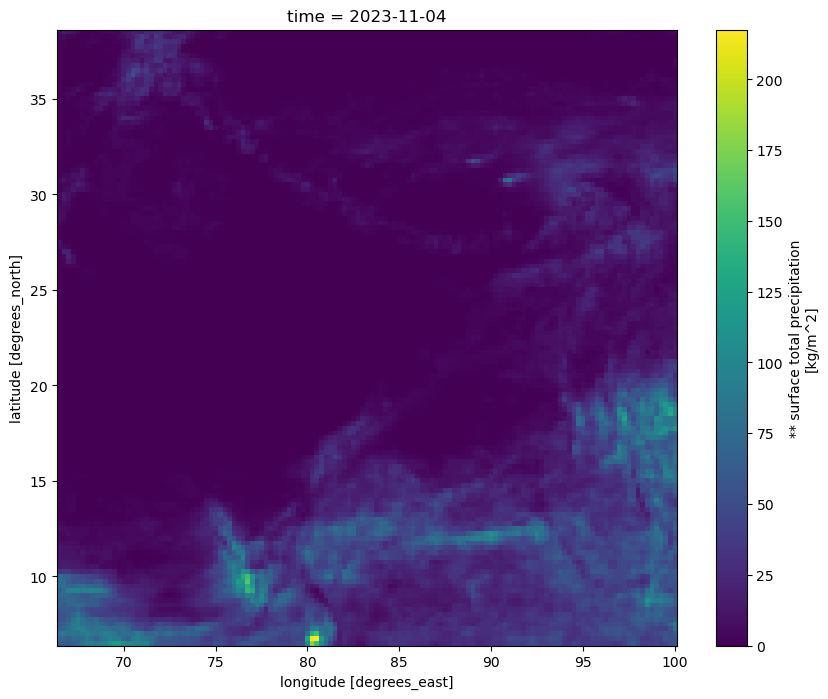

In [9]:
%matplotlib inline

# Plot the last timestep
dataset_gfs[varname].isel({'time':-1}).plot(figsize=(10,8))

### Extract a time-series from a single point within the GFS domain

In addition to examining the data in space, we can also examine the data over the `time` dimension. For simplicity, we will select one grid-cell from within the model subset domain (India), and plot the data for that cell over time. Again, `xarray` will know how to plot the data based on the number of dimensions (in this case just `time`), and plot the data with a line, labeling the axes with the coordinate values.

Extracting point time-series for point with (longitude,latitude) = ((76.586, 12.43))
Nearest grid point to (76.586, 12.43) is (76.5,12.5)


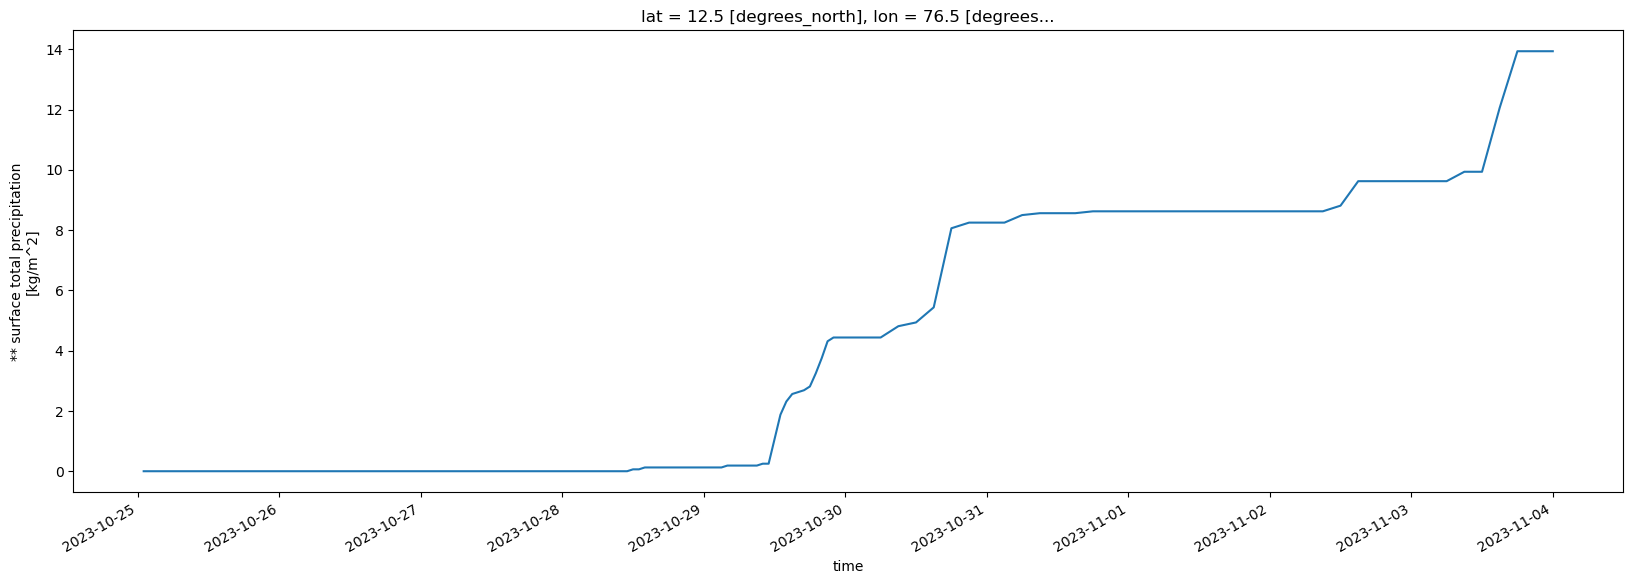

In [10]:
%matplotlib inline

# Select a location in the model's x,y coordinate system.
point_lon_lat = (76.586, 12.43)    # KRS Dam
print(f'Extracting point time-series for point with (longitude,latitude) = ({point_lon_lat})')

# Use nearest neighbor method to extract the grid cell closest to the desired point
ds_point = dataset_gfs.sel(lat=point_lon_lat[1], lon=point_lon_lat[0], method="nearest")
print('Nearest grid point to {0} is ({1},{2})'.format(point_lon_lat, 
                                                      float(ds_point['lon'].data), 
                                                      float(ds_point['lat'].data)))

# Plot the time-series
ds_point[varname].plot(figsize=(20,6))

### Plot precipitation rate for each timestep using bars

Note from the previous plot that the data represented by the variable `apcpsfc` is accumulated over time, and does not represent the precipitation at each timestep. We can easily calculate the time-step accumulation by differencing the data over the `time` dimension, using the `xarray` `.diff` method, and specifying the dimension over which to perform the operation. Once we calculate the precipitation over each time-step, this will give use a better sense of the precipitation intensity for this location over the model run. 

We will add some `matplotlib` plotting options to customize this plot. Remember that the default plot in xarray for time-series data is a line. If we wish to modify this plot to be a bar plot, we can take control of the plotting and setup `matplotlib` plot objects (`fig`, `ax`) and pass the axes to `xarray` to populate it.

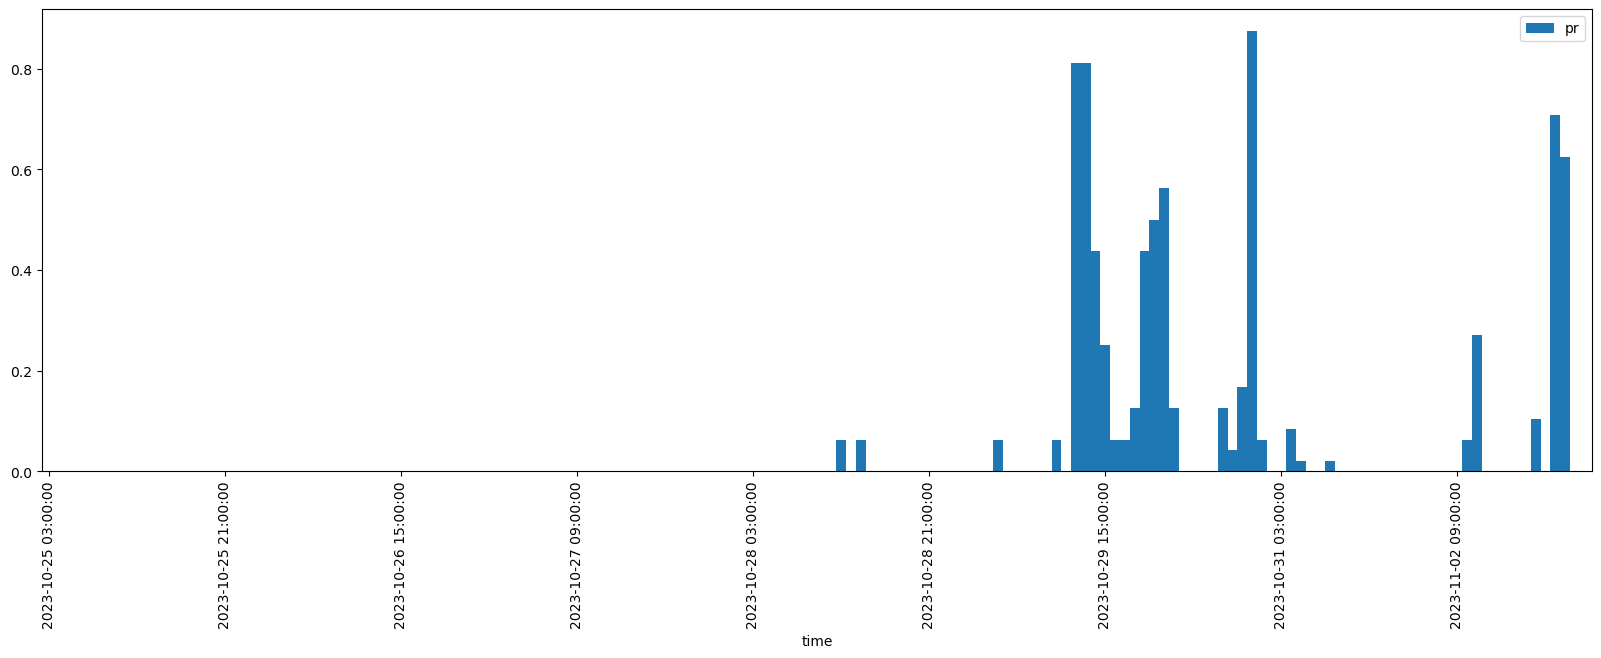

In [11]:
# De-accumulate from accumulated precipitation to timestep precip
precip_hourly = ds_point[varname].diff(dim='time')
precip_hourly.name = 'Surface Precipitation Rate [kg/m^2]'

# Timesteps have variable length in this dataframe. Normalize to accumulated precip per hour?
timestep_length_hrs = precip_hourly['time'].diff(dim='time') / pd.Timedelta(hours=1)
precip_hourly = precip_hourly / timestep_length_hrs
    
# For more control over the plot style, convert to pandas and use pyplot funcitons
fig, ax = plt.subplots(figsize=(20,6))
rain_df = precip_hourly.to_dataframe(name='pr').drop(columns=['lat', 'lon'])
rain_df = rain_df.reset_index()
rain_df = rain_df.set_index(rain_df['time'].dt.strftime('%b-%d-%y'))
ax = rain_df.plot.bar(ax=ax, x='time', width=1)
ax.legend(loc=1)  
plt.locator_params(axis='x', nbins=9)

### Calculate a daily 2D precipitation totals for each forecast day

Another way we may wish to examine this data is to resample the time-period and look at the spatial distribution of accumulated precipitation over each day in the forecast. We can easily do this by de-accumulating the `apcpsfc` variable as we did before, but while preserving the 2D spatial components of the original data. Again, we will perform the difference over time using the `.diff` function within `xarray`, specifying `time` as the dimension to perform the operation over. The result of this operation is a DataArray, since we specify only one variable as input to the `diff` operation. Because the precipitation data is no longer accumulated, we will change the variable name to `pr` (precipitation rate). Then, we will resample to daily using the time-aggregation string `"1D"` in the [`.resample`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.resample.html) function, and specify that we wish to compute the sum over each new time-period. Finally, we will convert the data back into a DataSet (from a DataArray). The result will be a DataSet of daily total precipitation.

In [12]:
%%time                     

# Isolate the precipitation in the first timestep
t1_precip = dataset_gfs[varname].isel({'time':0})     

# Calculate difference over time to de-accumulate precipitation
precip_hourly_2d = dataset_gfs[varname].diff(dim='time', label='upper') 

# Clip off the final time-step since it will be labeled with the following day (0Z)
precip_hourly_2d = precip_hourly_2d.isel({'time':slice(None, -1, None)})

# Concatenate first time-step precip with the de-accumulated precip for all subseqent timesteps
precip_hourly_2d = xr.concat([t1_precip, precip_hourly_2d], dim='time')

# Rename the DataArray name
precip_hourly_2d.name = 'pr'

# Calculate the sum of precip for each day
daily_precipitation = precip_hourly_2d.resample(time="1D").sum().to_dataset()
daily_precipitation['pr']/=24.                                      # Ensure units are in mm/h
daily_precipitation['pr'].attrs = precip_hourly_2d.attrs            # Add variable attributes
daily_precipitation['pr'].attrs['units'] = 'mm/hr'                  # Change units to account for daily total precip
daily_precipitation

Wall time: 18.6 ms


<xarray.Dataset>
Dimensions:  (time: 10, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2023-10-25 2023-10-26 ... 2023-11-03
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    pr       (lat, lon, time) float32 0.3125 0.4401 0.03385 ... 0.0 0.0 0.07552

### Plot the 2D precipitation totals for each forecast day

#### Plot each forecast day as a separate `facet` in the resulting plot

`Xarray` has many [plotting options](https://docs.xarray.dev/en/latest/user-guide/plotting.html). One is the ability to show a gridded array as an image (`.imshow`) and we can create a faceted plot with multiple images. In this case, we want to visualize the daily accumulated precipitation for each day in the GFS forecast. The result of the previous resampling operation will be a dataset of 10 or 11 forecast days, depending on the initialization time of the forecast. Thus, we will want the faceted plot to show 1 week of data on each row, and we will secify that it should wrap the columns each 7 values (`col_wrap=7`). Further, we will specify the precipitation color-ramp that we defined earlier and set a minimum valid value to plot. 

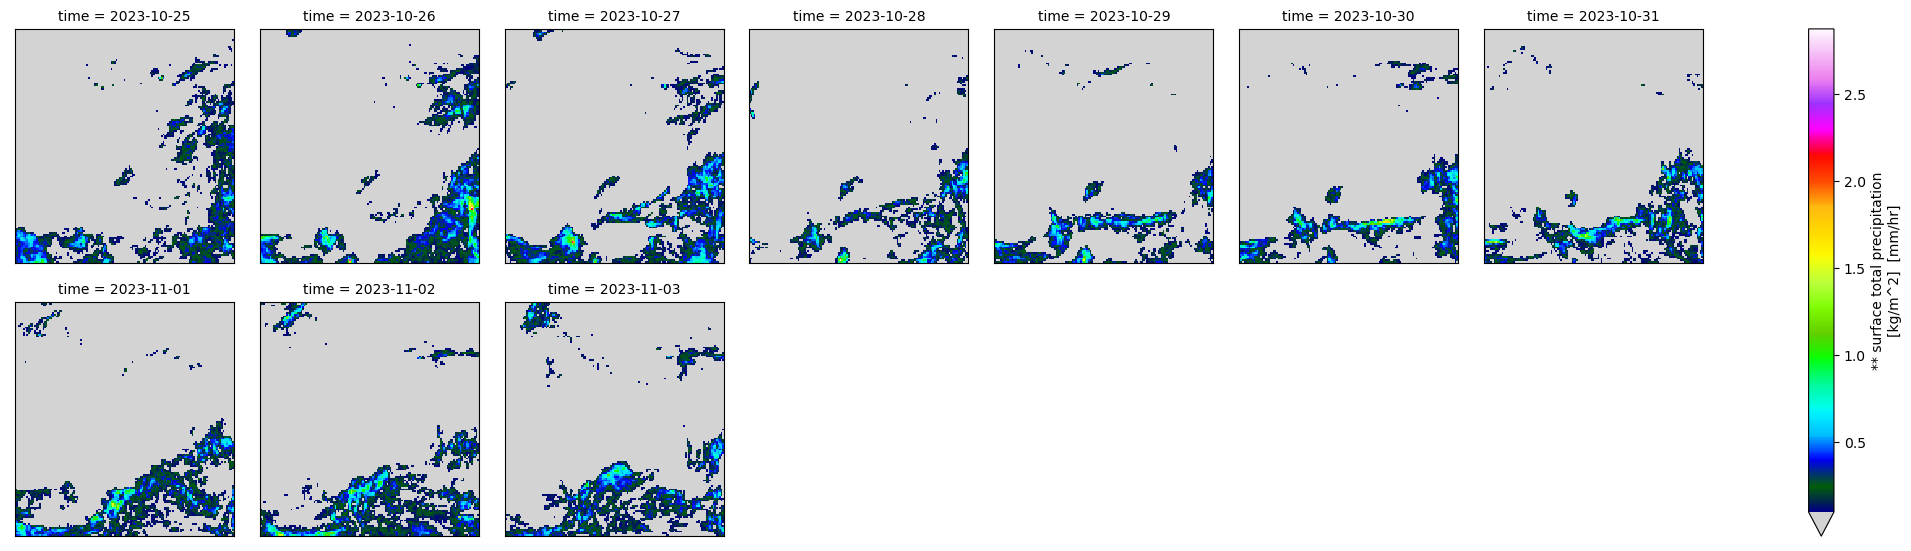

In [13]:
# Setup the plot into one week per row
facets = daily_precipitation['pr'].plot.imshow(x="lon", y="lat", col='time', col_wrap=7, cmap=cmap, vmin=0.1)

# Plot options to remove x and y labels, but add coordinates as title
facets.set_xlabels('')
facets.set_ylabels('')
facets.set_axis_labels('')
facets.set_titles()        # This will set a title for each plot likt '{coord} = {value}'

# Fix some remaining issues at the axis level
for i, ax in enumerate(facets.axes.flat):       
    #ax.set_title("Forecast Day {0}".format(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

### Save the GFS forecast data to local disk

In order to bring gridded multidimensional data into ArcGIS Pro, we must convert it to a file-based data format. The Network Common Data Format (netCDF) is used widely in the atmospheric sciences for multidimensional data. Here, we will use the xarray command `.to_netcdf` on the xarray DataSet object to write the full GFS forecast time-series to disk.

In [14]:
%%time

# Save the file to disk using info about the forecast model and initialization time
if load_nomads:
    model_info = os.path.basename(request_url_1hr)
    time_base = os.path.basename(os.path.dirname(request_url_1hr))
else:
    # Gather info from the input filename
    model_info = in_filename.split('_gfs')[0]
    time_base = in_filename.split('z_')[1].split('.nc')[0]
    time_base = time_base.split('_in')[0]

# Flip the dimensions - This is critical for Esri to understand the data
precip_hourly_2d = precip_hourly_2d.transpose("time", "lat", "lon")
daily_precipitation = daily_precipitation.transpose("time", "lat", "lon")

# Save the hourly processed data
out_basename = '{0}_{1}'.format(model_info, time_base)
out_file = os.path.join(output_data_dir, out_basename+'.nc')
print('Writing forecast data to file: {0}'.format(out_file))
precip_hourly_2d.to_netcdf(out_file, encoding={"time": {"dtype": "float64"}}) #, 'pr':{'_FillValue':'9.999e+20f', 'missing_value':'9.999e+20f'}})
    
# Save the daily processed data
out_basename2 = '{0}_{1}_{2}'.format(model_info, time_base, 'daily')
out_file_daily = os.path.join(output_data_dir, out_basename2+'.nc')
print('Writing daily forecast data to file: {0}'.format(out_file_daily))
daily_precipitation.to_netcdf(out_file_daily, encoding={"time": {"dtype": "float64"}}) #, 'pr':{'_FillValue':'9.999e+20f', 'missing_value':'9.999e+20f'}})

Writing forecast data to file: C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\output\gfs_0p25_1hr_00z_gfs20231025.nc
Writing daily forecast data to file: C:\Users\ksampson\Desktop\GloFAS_Q2Q_Bias_Correction_and_Verification\data\output\gfs_0p25_1hr_00z_gfs20231025_daily.nc
Wall time: 25.4 ms


### Now we will examine this data in ArcGIS Pro outside of the Notebook

We will save this file for later and attempt to bias-correct it using archives of GFS forecasts.

In [15]:
aprx.save()

## Examine the archived GFS 0.25 degree data for India

NCAR has put together an archive of GFS precipitation data over India. This archive of gridded precipiatation forecasts includes forecast lead time, which adds utility when performing some bias-correction routines.

In [ ]:
input_NC = os.path.join(input_data_dir, "archives", "gfs_india_0p25deg_24hr_20160101_to_20201231.nc")
data_var = 'Precipitation'
time_coord = 'initialization_date'

### Explorre the gridded dataset using `xarray`

Once we have identified a multidimensional dataset to analyze, we will open it using the [xarray](https://xarray.dev/) library. 

For a single input file, the `open_dataset` method will open a netCDF file. There are many input options, but the library should 
be able to auto-detect much of the necessary information from the input file. The result is a [DataSet](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html#xarray.Dataset) object, which 
holds the structure of the input dataset, any associated dimension information, coordinates, and metadata. This object can be used to access and manipulate the data for analysis.

In [ ]:
# Open the dataset as an xarray object
ds = xr.open_dataset(input_NC)

# Get total size of the dataset on disk
dataset_size_GB = get_size_gb(ds)

# Pull out the lead times represented in this forecast data
lead_times = ds['lead'].values
timesteps = ds[time_coord].values

ds

Note that xarray was very fast in opening this large dataset. That is because xarray does not need to read the data in order to return a DataSet object. It simply opens the data and reads the header information, which contains the self-describing metadata that gives the dimensions, coordinates, data variables and other attributes in the input file. 
Xarray will wait until we need to access the data variables before it attempts to read the data.

In [ ]:
%matplotlib inline

# Choose a timestep with some significant precipitation
ds[data_var].isel({'initialization_date':500, 'ensemble':0, 'lead':0}).plot(figsize=(10,8), cmap=cmap)

### Pick a point and examine the data at one point (1-dimensional forecast analysis)

In [ ]:
point_lon_lat = (76.586, 12.43)    # KRS Dam
print(f'Extracting point time-series for point with (longitude,latitude) = ({point_lon_lat})')

# Use nearest neighbor method to extract the grid cell closest to the desired point
ds_point = ds.sel(lat=point_lon_lat[1], lon=point_lon_lat[0], method="nearest")
print('Nearest grid point to {0} is ({1},{2})'.format(point_lon_lat, 
                                                      float(ds_point['lon'].data), 
                                                      float(ds_point['lat'].data)))
ds_point

### Plot time-series of forecasted precipication for one lead time

In [ ]:
%matplotlib inline

# Plot a time series of precipitation for one lead time
lead_time = 24
ds_point['Precipitation'].sel(lead=lead_time).plot(figsize=(20,6))

### Plot time series for all lead-times

This plot will be a bit busy, but you can see how the precipitation time-series for various forecast lead times correlate. Further, there are some forecast lead times that exhibit more or less precipitation.

In [ ]:
%matplotlib inline

# Plot precipitation for this location with one line for each lead-time
ds_point['Precipitation'].plot(figsize=(20,6), hue='lead')

### Plot the forecasts as a function of time using a sequential color scale

Because we wish to plot time-series as a funciton of forecast lead time, it can be helpful to visually differentiate the lines using a sequential color ramp. Here we use the `autumn` color map and 
set a cycler to cycle through these colors when building the line plots. Further, you can temporally aggregate (or resample) the time series to limit the variations in the plotted data.

In [ ]:
# create colormap
#colors = plt.cm.viridis_r(np.linspace(0, 1, lead_times.shape[0]))
colors = plt.cm.autumn(np.linspace(0, 1, lead_times.shape[0]))

# Matplotlib options to set a specific color ramp for this plot
ax = plt.subplot(111)
fig = plt.gcf()
ax.set_prop_cycle('color', list(colors))
fig.set_size_inches(20,6)

# Temporal manipulation for plotting purposes
#ds_point['Precipitation'].resample({time_coord:"1M"}).mean().plot(ax=ax, hue='lead')
ds_point['Precipitation'].rolling({time_coord:30}, center=True).mean().dropna(time_coord).plot(ax=ax, hue='lead')
plt.show()

### Check out active map

Make sure that the map named **Precipitation** is your active map. You can confirm this by making sure the the map name is `Precipitation` in the Contents pane to the right. If not, then you can select the map named `Precipitation` from the open Maps above, and this will set that map as the active map. Or run the cell below to see which map is active.

In [ ]:
# Get available information from the current map document
aprx = arcpy.mp.ArcGISProject("current")
m = aprx.activeMap
print('Active Map Name: {0}'.format(m.name))

### We will now create a Multidimensional Raster Layer to perform geoprocessing using arcpy

Multidimensional Raster Layers are a way of representing data that contain multple dimensions. This data type behaves like a stack of individual rasters. We can create Multidimensional Raster Layers from netCDF data on disk. In this case, we will bring the GFS forecast archive into ArcGIS as a Multidimensional Raster Layer and then perform Zonal Statistics on the data against an area of interest.

In [ ]:
arcpy.md.MakeMultidimensionalRasterLayer?

### Make a multidimensional raster layer, specifying one lead time and one ensemble member

In [ ]:
%%time

# Output layer name
layer_name = "GFS_India_Precip_Archive"

# Dimension selection
Dimension_Values = "lead 0;ensemble 1"

# Create a Multidimensional Rater Layer in the current active Map
arcpy.md.MakeMultidimensionalRasterLayer(
    in_multidimensional_raster=input_NC,
    out_multidimensional_raster_layer=layer_name,
    variables=data_var,
    dimension_def="BY_VALUE",
    dimension_ranges=None,
    dimension_values=Dimension_Values,
    dimension="",
    start_of_first_iteration="",
    end_of_first_iteration="",
    iteration_step=None,
    iteration_unit="",
    template='MAXOF',
    dimensionless="DIMENSIONS",
    spatial_reference=None
)

### Perform Spatial Aggregation using a basin polygon

We will peform a powerful operation called `Zonal Statistics`, where a boundary is used to calculate statistics against a raster (multidmensional or not). Here, we will use a basin outline for the KRS reservoir, and extract a time series of statistics from the input precipitation dataset.

* [How the zonal statistics tools work](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-zonal-statistics-works.htm)
* [Zonal Statistics](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/zonal-statistics.htm)
* [Zonal Statistics as Table](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/zonal-statistics-as-table.htm)

In [ ]:
%%time

# Define the inputs and outputs
in_polys = os.path.join(input_data_dir, 'basins', 'KRS_Basin.shp')
out_table_name = "ZonalStats_KRS"
Out_Table = os.path.join(default_gdb, out_table_name)

# Run the Zonal Statistics as Table arcpy Spatial Analyst tool
arcpy.sa.ZonalStatisticsAsTable(
    in_zone_data=in_polys,
    zone_field="BasinID",
    in_value_raster=layer_name,
    out_table=Out_Table,
    ignore_nodata="DATA",
    statistics_type="MEAN",
    process_as_multidimensional="ALL_SLICES",
    percentile_values=[90],
    percentile_interpolation_type="AUTO_DETECT",
    circular_calculation="ARITHMETIC",
    circular_wrap_value=360
)

Notice that the output has been added as a Standalone Table in the Contents pane of our active map. Let's examine the output table by right-clicking on the table and selecting `Open`.

Notice that there is a row for each feature in the input polygons, as well as a row for each value in the dimensions of the Multidimensional Raster Layer tool. 

### Output Zonal Statistics table to pandas dataframe

This will allow us to easily plot time series using the `pandas` library

In [ ]:
#List the fields you want to include. I want all columns except the geometry
columns = [f.name for f in arcpy.ListFields(Out_Table) if f.type!="Geometry"] 
df = pd.DataFrame(data=arcpy.da.SearchCursor(Out_Table, columns), columns=columns)
df = df.set_index('StdTime')
df

In [ ]:
df['MEAN'].plot(figsize=(20,8))

### Visualizing ArcPy Chart objects

If you work with [Chart objects](https://pro.arcgis.com/en/pro-app/latest/arcpy/classes/chart.htm) in ArcPy, you can visualize these with rich notebook representations (new in ArcGIS Pro 2.6):

#### Plot a bar chart of zonal average precipitation

https://pro.arcgis.com/en/pro-app/latest/arcpy/charts/bar.htm

In [ ]:
%%time

c = arcpy.charts.Bar(x='StdTime', y='MEAN',
                     title="Basin average precipitation",
                     xTitle="Time", yTitle="Mean Basin Precipitation",
                     dataSource=Out_Table)

# You can add this chart to an existing layer
tableLayer = m.listTables(out_table_name)[0]
c.addToLayer(tableLayer)

# Display the chart in the notebook, here
c

You will see the chart populate under the `ZonalStats_KRS` table in the Contents pane. Right-click to open the chart and you can play with some of the chart capabilities.

### Save the project

In [ ]:
aprx.save()

### Reset the namespace

The following `%reset -f` command is a built-in command in Jupyter Notebook that will reset the namespace. This is good practice to run when you are finished with the notebook.

In [ ]:
%reset -f

# Next up - Bias Correcting a Gridded Precipitation Forecast

This concludes this lesson. In the next lesson we will look at extending bias-correction methods from 1D to 2-dimensions.

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Select `Command Pallette -> restart kernel`.**

© UCAR 2023